In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
#import fasttext ## embedings
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import spacy
import language_tool_python
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import gensim

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import stanza
import spacy
from nltk.corpus import stopwords

# Cargar el modelo de Stanza para el procesamiento de texto en inglés
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

# Número de stopwords en NLTK
stop_nltk = stopwords.words('english')
print("nltk:", len(stop_nltk))

# Cargar el modelo de spaCy para el procesamiento de texto en inglés
nlp_spacy = spacy.load('en_core_web_sm')

# Obtener stopwords de spaCy
stop_spacy = nlp_spacy.Defaults.stop_words
print("spacy:", len(stop_spacy))

# Unir las stopwords de NLTK y spaCy
stop_todas = list(stop_spacy.union(set(stop_nltk)))

# Ver el total de stopwords combinadas
print("Total stopwords combinadas:", len(stop_todas))

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json


INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic

nltk: 179
spacy: 326
Total stopwords combinadas: 382


In [ ]:
import spacy

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm')

In [ ]:
python -m spacy download en_core_web_lg

2024-11-15 16:52:15.972181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 16:52:16.015820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 16:52:16.028666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 16:52:20.719075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.1.0/en_core_web_lg-3.1.0-py3-none-any.whl#egg=en_core_web_lg==3.1.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behavio

In [ ]:
path = "D:/Downloads/INTELIGENCIA ARTIFICIAL/Ejercicios Quiz/PUNTO 1 NEWS/"

In [ ]:
import gc
gc.collect()

3927

In [ ]:
archivo = "test_news.csv"
df = pd.read_csv(path + archivo)
df.head(2)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation


# PROCESAMIENTO

In [ ]:
tool = language_tool_python.LanguageTool('en')

INFO:language_tool_python.download_lt:Unzipping /tmp/tmp8gp68b0u.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.


In [ ]:
l = tool.check(df['headline_text'][0])
c = language_tool_python.utils.correct(df['headline_text'][0], l)

In [ ]:
for correccion in l:
    print(correccion)

Offset 0, length 3, Rule ID: UPPERCASE_SENTENCE_START
Message: This sentence does not start with an uppercase letter.
Suggestion: Aba
aba decides against community broadcasting ...
^^^


In [ ]:
df['matches'] = df['headline_text'].apply(lambda txt: tool.check(txt))  # Identificar reglas gramaticales para corregir
df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)  # Número de correcciones hechas dentro del texto
df['corregido'] = df.apply(lambda l: language_tool_python.utils.correct(l['headline_text'], l['matches']), axis=1)  # Obtener texto corregido


In [ ]:
sents = []  # formar listas con las oraciones de cada texto
tokens = []  # separar las palabras y caracteres de cada texto
lemma = []  # convertir las palabras en su raíz (ayuda --> ayudar)
pos = []  # indica en cada posición si la palabra es pronombre, conjunción, etc
ner = []  # indica si la palabra es considerada una entidad (nombre propio importante en el texto)

stop_words = set(STOP_WORDS)
# stop_words.update(punctuation) # remove it if you need punctuation

nlp = spacy.load('en_core_web_lg')   # Cargar modelo en español

# suppress numpy warnings
# np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(df['corregido'], batch_size=100, n_process=4):  # Procesar en lotes de 100, usando 4 núcleos
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.text.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

# Asignar los resultados al DataFrame df
df['tokens'] = tokens
df['lemma'] = lemma
df['pos'] = pos
df['sents'] = sents
df['ner'] = ner

<ipython-input-31-4305860d12dd>:16: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if essay.is_parsed:


In [ ]:
# Conteos de categorías gramaticales
df['token_count'] = df.apply(lambda x: len(x['tokens']), axis=1)
df['unique_token_count'] = df.apply(lambda x: len(set(x['tokens'])), axis=1)
df['nostop_count'] = df.apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
df['sent_count'] = df.apply(lambda x: len(x['sents']), axis=1)
df['ner_count'] = df.apply(lambda x: len(x['ner']), axis=1)
df['comma'] = df.apply(lambda x: x['corregido'].count(','), axis=1)
df['question'] = df.apply(lambda x: x['corregido'].count('?'), axis=1)
df['exclamation'] = df.apply(lambda x: x['corregido'].count('!'), axis=1)
df['quotation'] = df.apply(lambda x: x['corregido'].count('"') + x['corregido'].count("'"), axis=1)
df['organization'] = df.apply(lambda x: x['corregido'].count(r'@ORGANIZATION'), axis=1)
df['caps'] = df.apply(lambda x: x['corregido'].count(r'@CAPS'), axis=1)
df['person'] = df.apply(lambda x: x['corregido'].count(r'@PERSON'), axis=1)
df['location'] = df.apply(lambda x: x['corregido'].count(r'@LOCATION'), axis=1)
df['money'] = df.apply(lambda x: x['corregido'].count(r'@MONEY'), axis=1)
df['time'] = df.apply(lambda x: x['corregido'].count(r'@TIME'), axis=1)
df['date'] = df.apply(lambda x: x['corregido'].count(r'@DATE'), axis=1)
df['percent'] = df.apply(lambda x: x['corregido'].count(r'@PERCENT'), axis=1)
df['noun'] = df.apply(lambda x: x['pos'].count('NOUN'), axis=1)
df['adj'] = df.apply(lambda x: x['pos'].count('ADJ'), axis=1)
df['pron'] = df.apply(lambda x: x['pos'].count('PRON'), axis=1)
df['verb'] = df.apply(lambda x: x['pos'].count('VERB'), axis=1)
df['cconj'] = df.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
df['adv'] = df.apply(lambda x: x['pos'].count('ADV'), axis=1)
df['det'] = df.apply(lambda x: x['pos'].count('DET'), axis=1)
df['propn'] = df.apply(lambda x: x['pos'].count('PROPN'), axis=1)
df['num'] = df.apply(lambda x: x['pos'].count('NUM'), axis=1)
df['part'] = df.apply(lambda x: x['pos'].count('PART'), axis=1)
df['intj'] = df.apply(lambda x: x['pos'].count('INTJ'), axis=1)

In [ ]:
## Exportar tabla de salida
df['corregido'].to_pickle(path + 'new.pkl')

In [ ]:
df['processed_text'] = df.apply(lambda row: ' '.join(token.lemma_ for token in nlp(row["headline_text"]).sents), axis=1)
df['processed_text'] = df['processed_text'].str.lower()
df['processed_text'] = df['processed_text'].replace(list('áéíóú'), list('aeiou'), regex=True)
df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '', regex=True)
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_todas)]))
# df['processed_text'] = df['essay_text'].str.lower().str.replace(r'\W', ' ').str.split()


In [ ]:
df.to_pickle(path + 'news_corregido.pkl')

In [ ]:
datos=  pd.read_pickle(path + 'news_corregido.pkl')
datos.head(1)

,publish_date,headline_text,matches,corrected
0,20030219,aba decides against community broadcasting lic...,"[Offset 0, length 3, Rule ID: UPPERCASE_SENTEN...",Aba decides against community broadcasting lic...


In [ ]:
datos["headline_text"] = datos["processed_text"]
datos = datos.drop(columns=["processed_text"])

In [ ]:
datos = datos.get(['headline_text','publish_date'])

# FAST TEXT

In [ ]:
ft_model = fasttext.train_unsupervised(path + 'new.csv',dim=300)

In [ ]:
ft_model.save_model(path + "modelo_fasttext.bin")

In [ ]:
modelo = gensim.models.fasttext.load_facebook_vectors(path+'modelo_fasttext.bin')

In [ ]:
modelo

In [ ]:
no_doc = np.random.randint(len(datos))
no_doc

1242780

In [ ]:
# Volcabulario del embedding
vocabulary = set(modelo.key_to_index.keys())

def doc_word_vectors(words, model, vocabulary, num_features):

    nwords = 0.
    no_found=[]
    doc=[]
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            doc.append(model.get_word_vector(word))
        else:
            no_found.append(word)



    return np.array(doc),no_found

emb0,no_found = doc_word_vectors(datos['tokens'].iloc[no_doc], model=modelo, vocabulary=vocabulary, num_features=modelo.dim)

print('Dimensión del Embedding:',emb0.shape)
print('\nPalabras no encontradas:\n\n',no_found)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.get_word_vector(word))

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.words)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.get_word_vector(word))

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.words)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
ftext_feature_array = averaged_word_vectorizer(corpus=datos['tokens'], model=modelo, num_features=modelo.dim)

In [ ]:
doc_embedding = pd.DataFrame(ftext_feature_array)
doc_embedding.head()

In [ ]:
doc_embedding.to_csv(path + 'news_embeddings.csv')

In [ ]:
doc_embedding = pd.read_csv(path + 'news_embeddings.csv',index_col=0)

In [ ]:
doc_embedding.head(1)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.083881,0.297771,-0.10241,-0.080213,0.19162,-0.158806,0.001344,0.047068,-0.050211,0.005229,...,0.082435,-0.056275,0.117205,0.115417,0.160806,-0.016259,-0.132989,0.392937,0.092224,0.197642


In [ ]:
pca = PCA(n_components=30, random_state=0)
pcs = pca.fit_transform(doc_embedding.values)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_pcs = scaler.fit_transform(pcs)

In [ ]:
import pickle
with open(path + 'scaler_fast.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(path + 'pca_fast.pkl', 'wb') as file:
    pickle.dump(pca, file)

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.03966479 0.07283313 0.10033991 0.12129615 0.14034355 0.15644115
 0.1711159  0.18443343 0.19617636 0.20705826 0.21736478 0.22702087
 0.23653064 0.24571019 0.25432893 0.26265752 0.27051724 0.27821135
 0.28566094 0.29291204 0.29993706 0.30683672 0.31351659 0.32018629
 0.32657834 0.33296029 0.3391096  0.34508505 0.35083309 0.35655642]


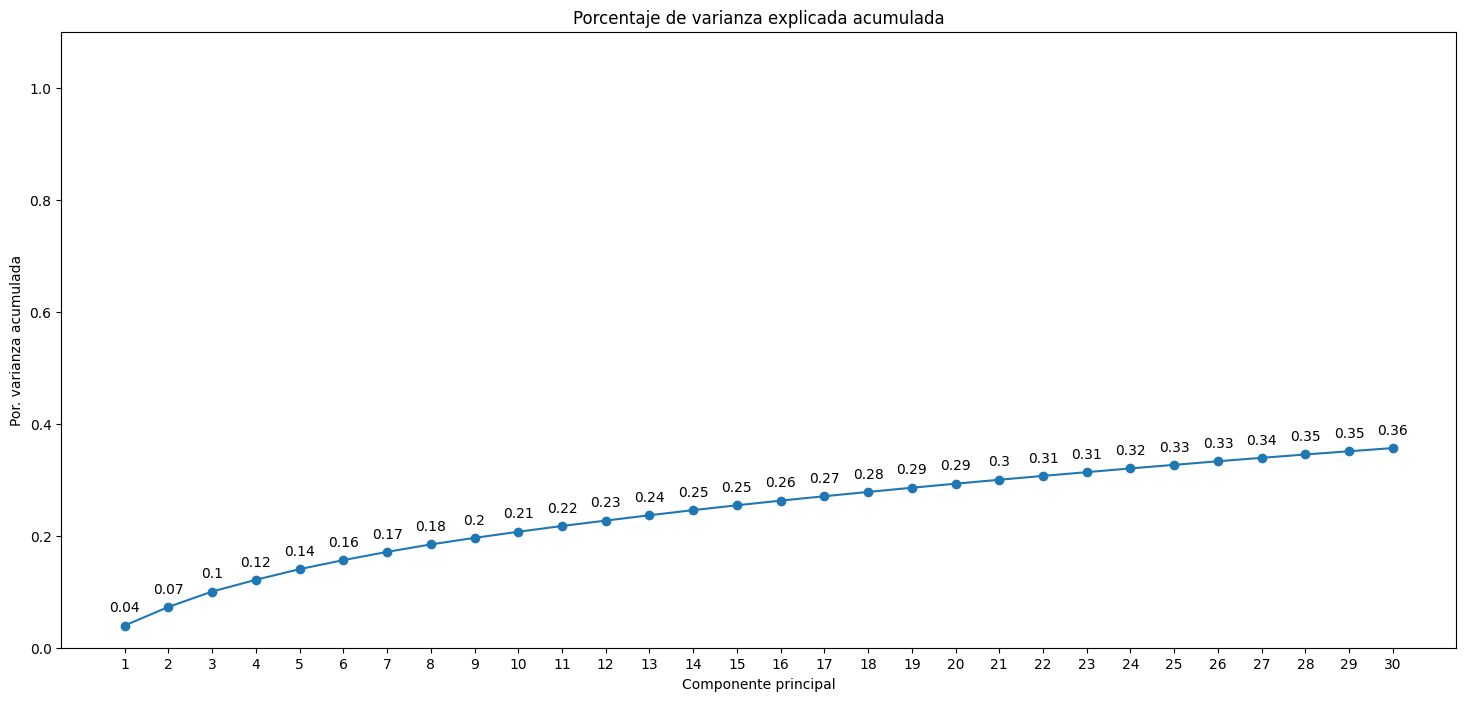

In [ ]:
%matplotlib inline

# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
ax.plot(
    np.arange(pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(pca.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

#ax.axvline(x=11, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
plt.show()

In [ ]:
%%time
from sklearn.metrics import silhouette_score

n_max = 10
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, n_max):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_pcs)
    score = silhouette_score(scaled_pcs, kmeans.labels_)
    silhouette_coefficients.append(score)

# EL NUMERO OPTIMO DE CLUSTER ES 3

In [ ]:
K_ = 3
km = KMeans(n_clusters=K_, random_state=0)
km.fit_transform(scaled_pcs)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['Grupo'])

In [ ]:
with open(path + 'km_fast.pkl', 'wb') as file:
    pickle.dump(km, file)

In [ ]:
cluster_labels.value_counts()

Grupo
2        569530
0        401064
1        273590
Name: count, dtype: int64

In [ ]:
datos["FAST"] = km.labels_
datos.head()

,headline_text,publish_date,FAST
0,aba decides against community broadcasting lic...,20030219,0
1,act fire witnesses must be aware of defamation,20030219,2
2,a g calls for infrastructure protection summit,20030219,0
3,air nz staff in aust strike for pay rise,20030219,0
4,air nz strike to affect australian travellers,20030219,2


In [ ]:
## Exportar tabla de salida
datos.to_pickle(path + 'datos_fast_text.pkl')

In [ ]:
datos =  pd.read_pickle(path + 'datos_fast_text.pkl')

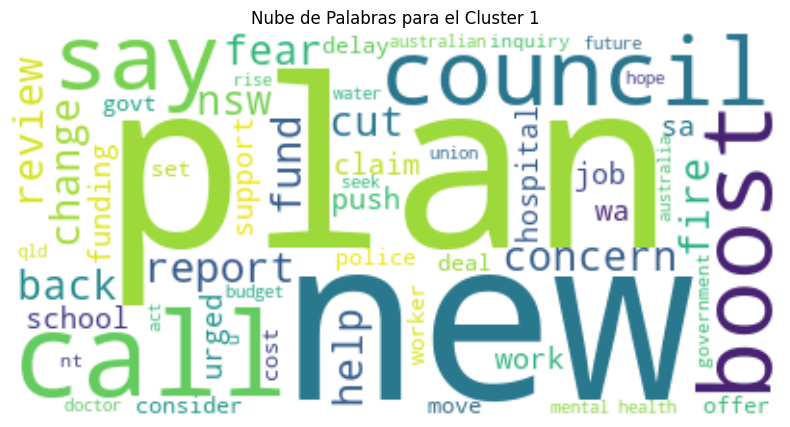

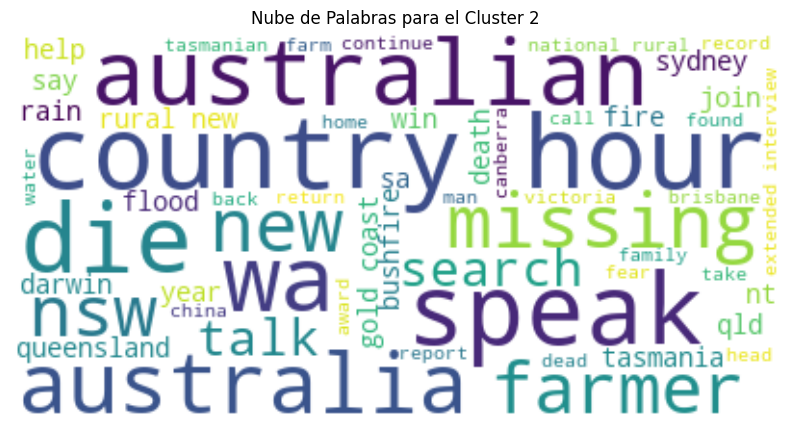

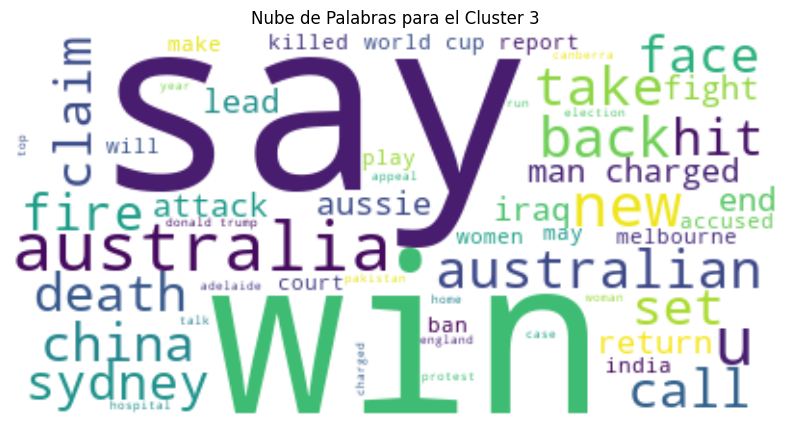

In [ ]:
for i in range(km.n_clusters):
    cluster_texts = datos[datos['FAST'] == i]["headline_text"]
    wordcloud = WordCloud(max_words=55, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

# CLUSTER 0 => POLITICAS PUBLICAS
# CLUSTER 1 => CLIMAS EXTREMOS
# CLUSTER 2 => INTERNACIONALES

# BERT

In [ ]:
from transformers import BertTokenizer, BertModel

# Cargar el tokenizador y el modelo BERT preentrenados
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Obtener embeddings con BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # Usar la representación de la [CLS] token
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding.flatten()

# Aplicar BERT a cada texto
df['bert_embedding'] = df['processed_text'].apply(get_bert_embedding)

# Convertir embeddings a una matriz para PCA y clustering
embeddings = np.stack(df['bert_embedding'].values)
np.save(path + 'news_embeddings_bert.npy', embeddings)

In [ ]:
embeddings = np.load(path + 'news_embeddings_bert.npy')

In [ ]:
pca = PCA(n_components=30)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
# Normalizar los embeddings PCA para que estén escalados entre -1 y 1 (opcional pero recomendado)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_pcs = scaler.fit_transform(embeddings_pca)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
datos['cluster'] = kmeans.labels_

In [ ]:
datos.head()

,headline_text,publish_date,FAST,cluster
0,aba decides against community broadcasting lic...,20030219,0,2
1,act fire witnesses must be aware of defamation,20030219,2,0
2,a g calls for infrastructure protection summit,20030219,0,0
3,air nz staff in aust strike for pay rise,20030219,0,1
4,air nz strike to affect australian travellers,20030219,2,1


In [ ]:
datos.to_pickle(path + 'datos_fastest_bert.pkl')

In [ ]:
datos =  pd.read_pickle(path + 'datos_fastest_bert.pkl')

In [ ]:
import pickle
with open(path + 'kmeans_bert.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

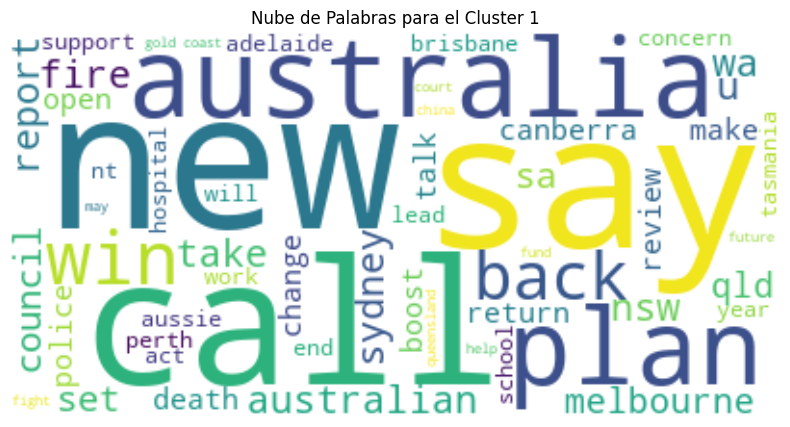

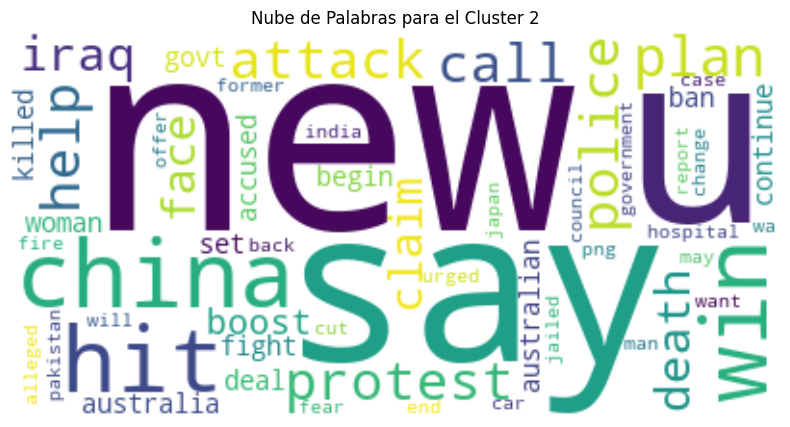

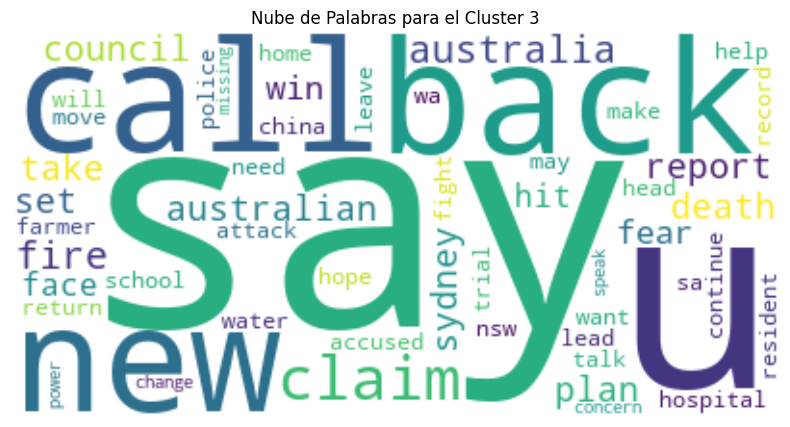

In [ ]:
for i in range(kmeans.n_clusters):
    cluster_texts = datos[datos['cluster'] == i]['headline_text']
    wordcloud = WordCloud(max_words=55, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

# LDA

In [ ]:
from nltk.stem import PorterStemmer

def lemmatize_stemming(text):
    ps = PorterStemmer()
    return ps.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text): #  gensim.utils.simple_preprocess tokeniza el texto
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
documents = datos

In [ ]:
doc_sample = documents[documents['publish_date'] == 20030219]['headline_text'].values[0]

words = []
for word in doc_sample.split(' '):
    words.append(word)
processed_docs = documents['headline_text'].map(preprocess)

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=500)

In [ ]:
dictionary.save("dictionary.dict")

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# LDA SIN TFIDF

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)

In [ ]:
lda_model.save(path + "modelo_lda_wo.bin")

In [ ]:
ind_without_tfidf = lda_model[bow_corpus]

In [ ]:
topics_wo = []
for y in range(datos.shape[0]):
    if len(ind_without_tfidf[y]) > 0:
        valid_sublist = [sublist for sublist in ind_without_tfidf[y] if len(sublist) > 1]
        if len(valid_sublist) > 0:
            max_index = np.argmax([sublist[1] for sublist in valid_sublist])
            topics_wo.append(valid_sublist[max_index][0])
        else:
            topics_wo.append(None)
    else:
        topics_wo.append(None)

In [ ]:
datos["LDA_wo"] = topics_wo
datos.head()

,headline_text,publish_date,FAST,cluster,LDA_wo
0,aba decides against community broadcasting lic...,20030219,0,2,0
1,act fire witnesses must be aware of defamation,20030219,2,0,0
2,a g calls for infrastructure protection summit,20030219,0,0,0
3,air nz staff in aust strike for pay rise,20030219,0,1,2
4,air nz strike to affect australian travellers,20030219,2,1,2


In [ ]:
datos["LDA_wo"].value_counts()

LDA_wo
0    501955
2    377761
1    364468
Name: count, dtype: int64

In [ ]:
topic_list = [x for x in datos["LDA_wo"].unique()]
topic_list = [x for x in np.sort(topic_list)]
topic_list

[0, 1, 2]

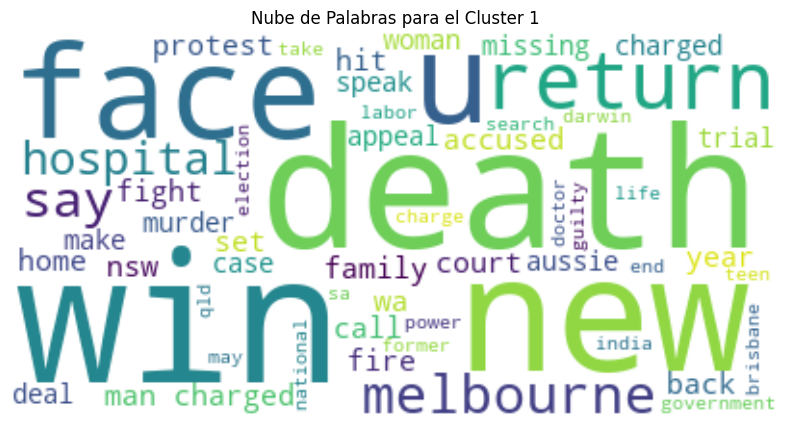

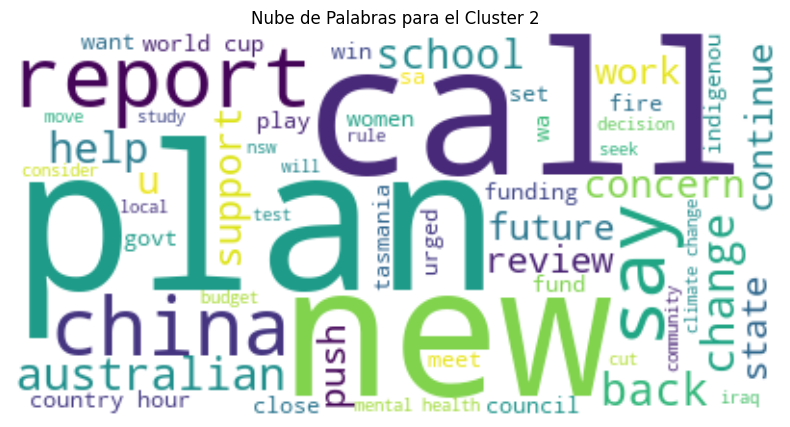

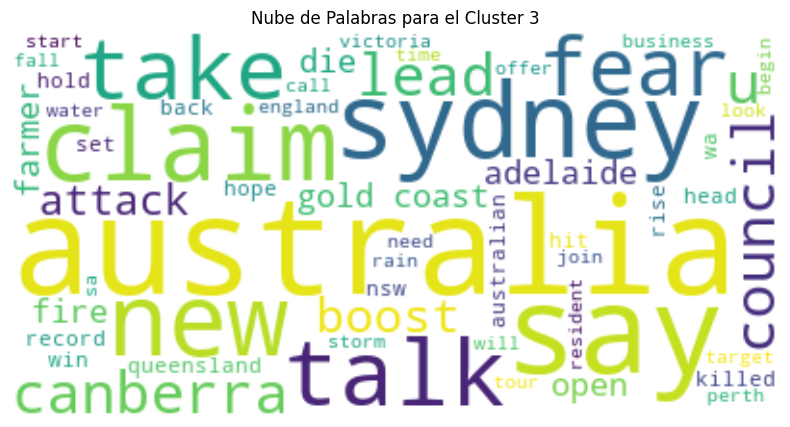

In [ ]:
for i in range(len(topic_list)):
    cluster_texts = datos[datos["LDA_wo"] == i]['headline_text']
    wordcloud = WordCloud(max_words=55, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

# LDA con TF IDF

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)

In [ ]:
lda_model_tfidf.save(path + "modelo_lda_tfidf.bin")

In [ ]:
ind_with_tfidf = lda_model_tfidf[bow_corpus]

In [ ]:
topics_with = []
for y in range(datos.shape[0]):
    if len(ind_with_tfidf[y]) > 0:
        valid_sublist = [sublist for sublist in ind_with_tfidf[y] if len(sublist) > 1]
        if len(valid_sublist) > 0:
            max_index = np.argmax([sublist[1] for sublist in valid_sublist])
            topics_with.append(valid_sublist[max_index][0])
        else:
            topics_with.append(None)
    else:
        topics_with.append(None)

In [ ]:
datos["LDA_tfidf"] = topics_with
datos.head(10)

,headline_text,publish_date,FAST,cluster,LDA_wo,LDA_tfidf
0,aba decides against community broadcasting lic...,20030219,0,2,0,2
1,act fire witnesses must be aware of defamation,20030219,2,0,0,0
2,a g calls for infrastructure protection summit,20030219,0,0,0,2
3,air nz staff in aust strike for pay rise,20030219,0,1,2,2
4,air nz strike to affect australian travellers,20030219,2,1,2,0
5,ambitious olsson wins triple jump,20030219,0,1,2,2
6,antic delighted with record breaking barca,20030219,2,0,2,2
7,aussie qualifier stosur wastes four memphis match,20030219,2,0,1,2
8,aust addresses un security council over iraq,20030219,0,1,0,1
9,australia is locked into war timetable opp,20030219,2,2,2,1


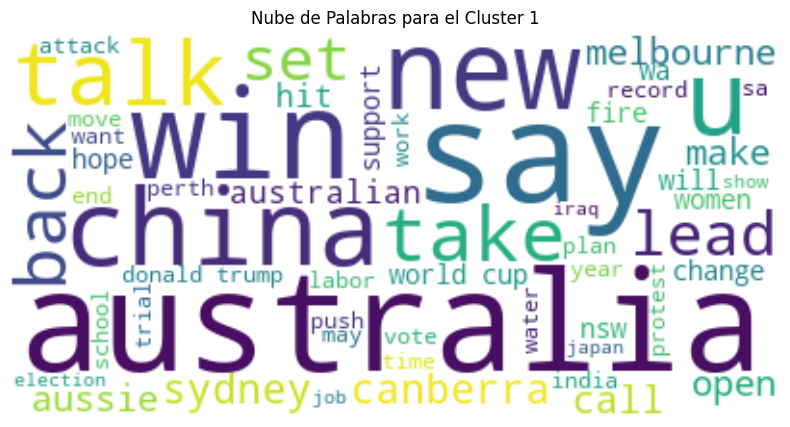

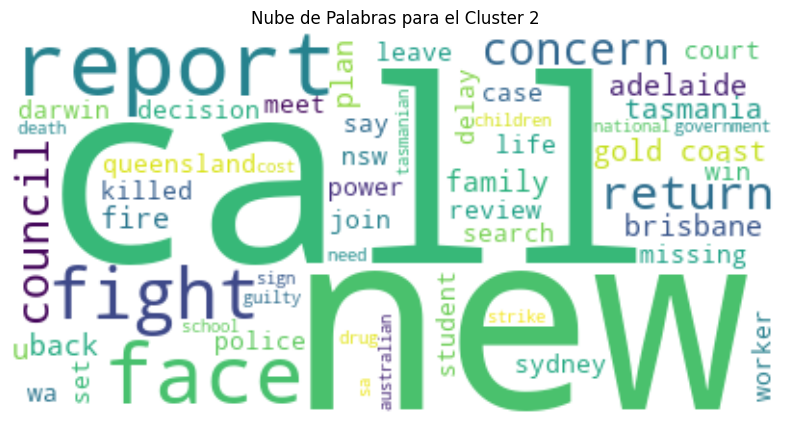

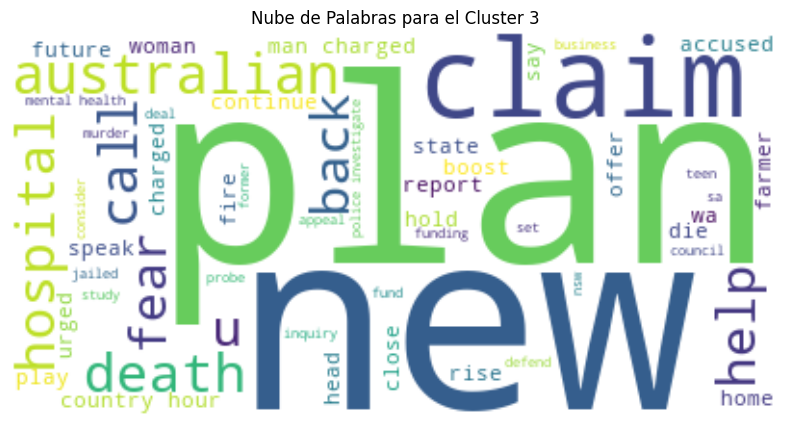

In [ ]:
for i in range(len(topic_list)):
    cluster_texts = datos[datos['LDA_tfidf'] == i]['headline_text']
    wordcloud = WordCloud(max_words=55, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

In [ ]:
datos.to_pickle(path + 'datos_completos.pkl')

In [ ]:
crosstabb =pd.crosstab(datos["FAST"],datos["cluster"])
crosstabb

cluster,0,1,2
FAST,,,
0,204593,85410,111061
1,143450,37783,92357
2,219158,146871,203501


In [ ]:
crosstab1 =pd.crosstab(datos["FAST"],datos["LDA_wo"])
crosstab1

LDA_wo,0,1,2
FAST,,,
0,206223,110935,83906
1,105643,77523,90424
2,190089,176010,203431


In [ ]:
crosstab2 =pd.crosstab(datos["FAST"],datos["LDA_tfidf"])
crosstab2

LDA_tfidf,0,1,2
FAST,,,
0,125880,157356,117828
1,117966,74818,80806
2,223034,170469,176027


In [ ]:
crosstabb_percentage = (crosstabb / crosstabb.sum().sum() * 100).round(0).astype(int)
crosstab1_percentage = (crosstab1 / crosstab1.sum().sum() * 100).round(0).astype(int)
crosstab2_percentage = (crosstab2 / crosstab2.sum().sum() * 100).round(0).astype(int)

print(crosstabb_percentage)
print(crosstab1_percentage)
print(crosstab2_percentage)

cluster   0   1   2
FAST               
0        16   7   9
1        12   3   7
2        18  12  16
LDA_wo   0   1   2
FAST              
0       17   9   7
1        8   6   7
2       15  14  16
LDA_tfidf   0   1   2
FAST                 
0          10  13   9
1           9   6   6
2          18  14  14


### CLUSTER
#### 1 = POLITICAS PUBLICAS
#### 0 = INTERNACIONALES
#### 2 = CLIMAS EXTREMOS

### LDA WO
#### 0 = POLITICAS PUBLICAS
#### 1 = INTERNACIONALES
#### 2 = CLIMAS EXTREMOS

### LDA TFIDF
#### 0 = INTERNACIONALES
#### 1 = POLITICAS PUBLICAS
#### 2 = CLIMAS EXTREMOS